* Julia code replication of:
" https://www.kaggle.com/victorchernozhukov/r-notebook-linear-penalized-regs "



This notebook contains an example for teaching.


# Penalized Linear Regressions: A Simulation Experiment

## Data Generating Process: Approximately Sparse

In [1]:
# #Needed Packages and extra just in case
# Pkg.add( "GLMNet" )
# Pkg.add("Plots")
# Pkg.add("Lathe")
# Pkg.add("GLM")
# Pkg.add("StatsPlots")
# Pkg.add("MLBase")
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Dates")
# Pkg.add("Plots")
# Pkg.add("Lasso")
# Pkg.add( "Distributions" )

In [2]:
using Pkg
using CSV
using DataFrames
using Dates
using Plots

# Load the installed packages
using DataFrames
using CSV
using Plots
using Lathe
using GLM
using Statistics
# using StatsPlots
using MLBase

using Lasso

# Import functions
using LinearAlgebra, GLM, DataFrames, Statistics, Random

using Distributions

using GLMNet

In [3]:
Random.seed!(1234)

TaskLocalRNG()

theoretical R2:0.8840363165570461

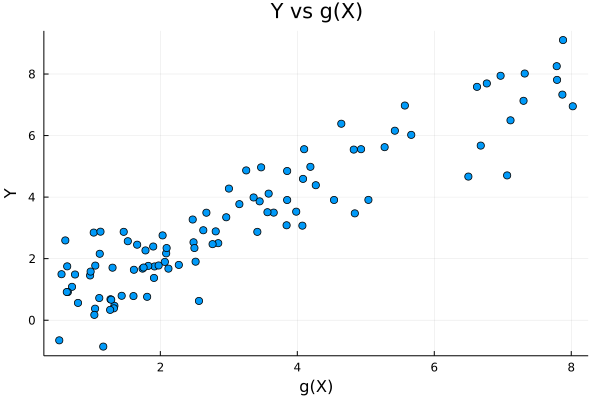

In [4]:
n = 100
p = 400
Z = rand( Uniform( 0, 1 ), n  ) .- 0.5
W = reshape( rand( Uniform( 0, 1 ), n * p  ), n, p )

beta = ( 1 ./ range( 1, p, step = 1 ) ) .^ 2

gX = exp.( Z .* 4  ) + W * beta

X = hcat( Z, Z .^ 2, Z .^ 3, W )

mean = 0
sd = 1

Y = gX + randn( n )

print( "theoretical R2:", var(gX) / var( Y ) )

plt = plot( gX, Y, 
    seriestype = :scatter, 
    title = "Y vs g(X)",
    label = "", 
    lw = 3)
xlabel!( "g(X)" )
ylabel!( "Y" )
display( plt )


We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net

In [5]:
fit_lasso_cv = glmnetcv(X, Y, alpha = 1)
fit_ridge   = glmnetcv(X, Y, alpha=0)
fit_elnet   = glmnetcv(X, Y, alpha=.5)

yhat_lasso_cv = GLMNet.predict( fit_lasso_cv, X )
yhat_ridge = GLMNet.predict( fit_ridge, X )
yhat_elnet = GLMNet.predict( fit_elnet, X )

data = DataFrame( lasso_cv = ( gX - yhat_lasso_cv ) .^ 2, 
                  ridge = ( gX - yhat_ridge ) .^ 2, 
                elnet = ( gX - yhat_elnet ) .^ 2 )

lasso_mse_fit = fit( LinearModel, @formula( lasso_cv ~ 1 ), data )
ridge_mse_fit = fit( LinearModel, @formula( ridge ~ 1 ), data )
elnet_mse_fit = fit( LinearModel, @formula( elnet ~ 1 ), data )

MSE_lasso_cv  = [ GLM.coef( lasso_mse_fit )[ 1 ], stderror( lasso_mse_fit )[1] ]
MSE_ridge  = [ GLM.coef( ridge_mse_fit )[ 1 ], stderror( ridge_mse_fit )[1] ]
MSE_elnet  = [ GLM.coef( elnet_mse_fit )[ 1 ], stderror( elnet_mse_fit )[1] ]

2-element Vector{Float64}:
 0.2321188265804949
 0.03590433444686037

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

In [43]:
include("hdmjl/hdmjl.jl")
# fit(LassoModel, 
Data = DataFrame(X)
Data.y = Y
select!(Data, :y, All())
fit_rlasso = fit(LassoModel, term(:y) ~ sum(term.(names(Data, Not(:y)))), Data)
12
# x_data = DataFrame(X)
# y_data = DataFrame(Y)
# fit_rlasso_post = rlasso(x_data, y_data, nothing, true)
# yhat_rlasso = predict(fit_rlasso)

# y_data = DataFrame(
#     r_lasso = (gX - yhat_rlasso).^2
#     )

# MSE_rlasso = fit(LinearModel, @formula(r_lasso ~ 1), data)


12

In [48]:
fit(LassoModel, term(:y) ~ sum(term.(names(Data, Not(:y)))), Data)

StatsModels.TableRegressionModel{LassoModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, MinAICc}, Matrix{Float64}}

y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 + x61 + x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 + x71 + x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 + x81 + x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 + x91 + x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 + x101 + x102 + x103 + x104 + x105 + x106 + x107 + x108 + x109 + x110 + x111 + x112 + x113 + x114 + x115 + x116 + x117 + x118 + x119 + x120 + x121 + x122 + x123 + x124 + x125 + x126 + x127 + x128 + x129 + x130 + x131 + x1

In [50]:
x_data = DataFrame(X)
y_data = DataFrame(Y)
rlasso(x_data, y_data)

LoadError: ArgumentError: 'Vector{Float64}' iterates 'Float64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

Next we code up lava, which alternates the fitting of lasso and ridge

### Summary

In [6]:
msa = [MSE_lasso_cv[1], MSE_ridge[1], MSE_elnet[1]]
se_msa = [MSE_lasso_cv[2], MSE_ridge[2], MSE_elnet[2]]
model = ["Cross-Validated Lasso", "Cross-Validated Ridge", "Cross-validated Elnel"]
DataFrame(Model = model, MSA = msa, SE_for_MSA = se_msa)
# se_msa

,Model,MSA,SE_for_MSA
,String,Float64,Float64
1,Cross-Validated Lasso,0.218296,0.0278839
2,Cross-Validated Ridge,1.85149,0.239124
3,Cross-validated Elnel,0.232119,0.0359043


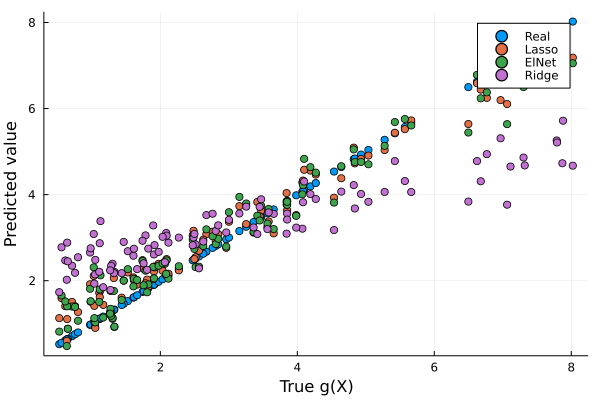

In [7]:
scatter(gX, gX, label = "Real")
scatter!(gX, yhat_lasso_cv, label="Lasso")
scatter!(gX, yhat_elnet, label="ElNet")
scatter!(gX, yhat_ridge, label="Ridge")
yaxis!("Predicted value")
xaxis!("True g(X)")

# Data Generating Process: Approximately Sparse + Small Dense Part

theoretical R2:0.6045549947524766

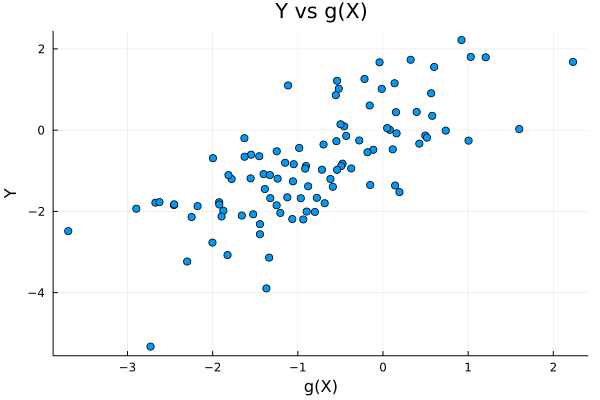

In [8]:
n = 100
p = 400

Z = rand(Uniform(0, 1), n) .- 0.5
W = reshape(rand(Uniform(0, 1), n * p), n, p)

beta = rand(Normal(), p) .* .2
gX = exp.(Z * .4) .+ W * beta
X = hcat(Z, Z.^2, Z.^3, W)

Y = gX + rand(Normal(), n)

print( "theoretical R2:", var(gX) / var( Y ) )

plt = plot( gX, Y, 
    seriestype = :scatter, 
    title = "Y vs g(X)",
    label = "", 
    lw = 3)
xlabel!( "g(X)" )
ylabel!( "Y" )
display( plt )


In [9]:
fit_lasso_cv = glmnetcv(X, Y, alpha = 1)
fit_ridge   = glmnetcv(X, Y, alpha=0)
fit_elnet   = glmnetcv(X, Y, alpha=.5)

yhat_lasso_cv = GLMNet.predict( fit_lasso_cv, X )
yhat_ridge = GLMNet.predict( fit_ridge, X )
yhat_elnet = GLMNet.predict( fit_elnet, X )

data = DataFrame( lasso_cv = ( gX - yhat_lasso_cv ) .^ 2, 
                  ridge = ( gX - yhat_ridge ) .^ 2, 
                elnet = ( gX - yhat_elnet ) .^ 2 )

lasso_mse_fit = fit( LinearModel, @formula( lasso_cv ~ 1 ), data )
ridge_mse_fit = fit( LinearModel, @formula( ridge ~ 1 ), data )
elnet_mse_fit = fit( LinearModel, @formula( elnet ~ 1 ), data )

MSE_lasso_cv  = [ GLM.coef( lasso_mse_fit )[ 1 ], stderror( lasso_mse_fit )[1] ]
MSE_ridge  = [ GLM.coef( ridge_mse_fit )[ 1 ], stderror( ridge_mse_fit )[1] ]
MSE_elnet  = [ GLM.coef( elnet_mse_fit )[ 1 ], stderror( elnet_mse_fit )[1] ]

2-element Vector{Float64}:
 1.1008626017832157
 0.1602045819517743

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

Next we code up lava, which alternates the fitting of lasso and ridge

### Summary

In [10]:
msa = [MSE_lasso_cv[1], MSE_ridge[1], MSE_elnet[1]]
se_msa = [MSE_lasso_cv[2], MSE_ridge[2], MSE_elnet[2]]
model = ["Cross-Validated Lasso", "Cross-Validated Ridge", "Cross-validated Elnel"]
DataFrame(Model = model, MSA = msa, SE_for_MSA = se_msa)
# se_msa

,Model,MSA,SE_for_MSA
,String,Float64,Float64
1,Cross-Validated Lasso,1.10086,0.160205
2,Cross-Validated Ridge,0.535408,0.0865959
3,Cross-validated Elnel,1.10086,0.160205


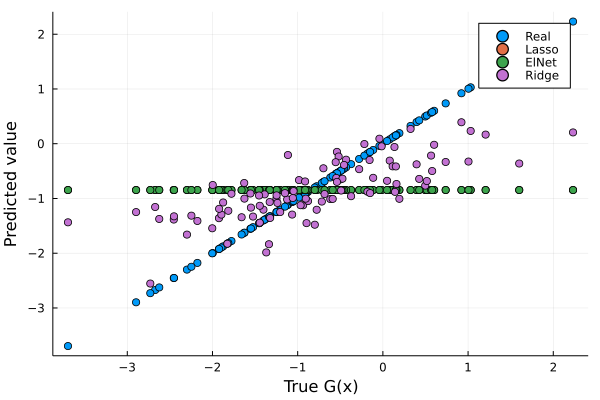

In [11]:
scatter(gX, gX, label = "Real")
scatter!(gX, yhat_lasso_cv, label="Lasso")
scatter!(gX, yhat_elnet, label="ElNet")
scatter!(gX, yhat_ridge, label="Ridge")
yaxis!("Predicted value")
xaxis!("True G(x)")